In [29]:
from pytfa.io.json import load_json_model
#from skimpy.io.yaml import  load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.core.parameters import ParameterValues
from skimpy.utils.namespace import *
from skimpy.core.modifiers import *
from skimpy.io.yaml import load_yaml_model
from skimpy.core.reactor import Reactor
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.viz.plotting import timetrace_plot
from pytfa.io.json import load_json_model
from skimpy.io.yaml import load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations
from skimpy.core.parameters import load_parameter_population
from skimpy.simulations.reactor import make_batch_reactor
from skimpy.core.solution import ODESolutionPopulation
from skimpy.utils.namespace import *
from skimpy.viz.escher import animate_fluxes, plot_fluxes
import copy
from skimpy.io.yaml import export_to_yaml
from skimpy.analysis.ode.utils import make_flux_fun

import pandas as pd
import numpy as np

import skimpy
import time
import matplotlib.pyplot as plt
import itertools
import matplotlib
import sys
sys.path.insert(1, '../functions/')

# benchmark functions
import simulation_functions as sf
import scenarios as sc
import visualizations as vis
import noise as noise

#ML methods
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import  AdaBoostRegressor
from scipy.stats import linregress

In [30]:
def test_set1_Xy(cart,cart_scenario,enz_names,test_set_size):
    """testing on a set of unseen examples
    - cart: set of designs from the full combinatorial space
    - cart_scenario: trainingset
    - N: size of the test_set"""
    test_cart=[]
    test_set_design=[]
    for i in cart:
        for j in cart_scenario:
            if i!=j:
                test_cart.append(i)
    index_set=np.arange(0,len(test_cart),1)
    random_choice=np.random.choice(index_set,test_set_size,replace=False)
    
    test_cart=[test_cart[i] for i in random_choice]
    cart_ind=test_cart
    #make a designlist from test
    for i in test_cart:
        temp=dict(zip(enz_names,i))
        test_set_design.append(temp)
    #make it a dataframe for prediction
    test_cart=pd.DataFrame(test_cart,columns=enz_names)
    return test_cart,test_set_design,cart_ind

def ML_methods(train_x,train_y,test_x,test_y):
    "wrapper s.t. we can call it iteratively for each scenario"
    #train test split
    #X=['vmax_forward_Enzyme_A','vmax_forward_Enzyme_B',"vmax_forward_Enzyme_C",
     #  "vmax_forward_Enzyme_D","vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"]
    #train_x=training_set_sc1[X]
    #train_y=training_set_sc1['Enzyme_G']
    #test_x=test_set_simulation[X]
    #test_y=test_set_simulation['Enzyme_G']
    
    #svr
    regr_svr = svm.SVR()
    regr_svr.fit(train_x, train_y)
    prediction_svr=regr_svr.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,prediction_svr)
    score_svr=r_value**2
    
    #score_svr=regr_svr.score(test_x,test_y)
    #print("Support Vector Regressor: "+str(regr_svr.score(test_x,test_y)))
    #sgd
    regr_sgd = make_pipeline(StandardScaler(),SGDRegressor(loss="squared_error",max_iter=1000, tol=1e-3))
    regr_sgd.fit(train_x, train_y)
    predict_sgd=regr_sgd.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_sgd)
    score_sgd=r_value**2
    

    #print("Stochastic Gradient Descent Regressor: "+str(regr_sgd.score(test_x,test_y)))
    #rf
    regr_rf = RandomForestRegressor()
    regr_rf.fit(train_x, train_y)
    predict_rf=regr_rf.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_rf)
    score_rf=r_value**2

    #print("Random Forest: "+str(regr_rf.score(test_x,test_y)))
    #Elastic Net
    regr_elasticnet=ElasticNet()
    regr_elasticnet.fit(train_x,train_y)
    predict_elasticnet=regr_elasticnet.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_elasticnet)
    score_elasticnet=r_value**2
    
    #print("Elastic Net: "+str(regr_elasticnet.score(test_x,test_y)))
    #KNN
    regr_knn=KNeighborsRegressor(n_neighbors=5,weights="distance")
    regr_knn.fit(train_x,train_y)
    predict_knn=regr_knn.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_knn)
    score_knn=r_value**2
    
    #print("k Nearest Neighbors: "+str(regr_knn.score(test_x,test_y)))
    #GPR
    regr_GPR=GaussianProcessRegressor()
    regr_GPR.fit(train_x,train_y)
    predict_GPR=regr_GPR.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_GPR)
    score_GPR=r_value**2
    
    #print("Gaussian Process Regressor: "+str(regr_GPR.score(test_x,test_y))) 
    #this is probably an algorithm that needs to be finetuned more
    #Gradient boosting Regressor
    regr_GradBoostReg=GradientBoostingRegressor()
    regr_GradBoostReg.fit(train_x,train_y)
    predict_GradBoostReg=regr_GradBoostReg.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_GradBoostReg)
    score_GradBoost=r_value**2
    
    #print("Gradient Boosting Regressor: "+str(regr_GradBoostReg.score(test_x,test_y))) 
    # Neural Network
    regr_NN=MLPRegressor(max_iter=8000,activation="relu", learning_rate="adaptive")
    regr_NN.fit(train_x,train_y)
    predict_NN=regr_NN.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_NN)
    score_NN=r_value**2
    
    #print("Neural Network: "+str(regr_NN.score(test_x,test_y))) 
    algorithms=["SVR","SGD","RF","EN","kNN","GPR","GBR","NN"]
    scores=[score_svr,score_sgd,score_rf,score_elasticnet,score_knn,score_GPR,score_GradBoost,score_NN]
    scores=dict(zip(algorithms,scores))
    return scores 



def test_unseen_designs(cart,enz_names,test_set_size):
    """testing predictions from """
    index_set=np.arange(0,len(cart),1)
    random_choice=np.random.choice(index_set,test_set_size,replace=False)
    test_cart=[cart[i] for i in random_choice]
    return test_cart


def find_set_designs(comb_space,tcart,enz_names):
    """finds the training or test set designs in the combinatorial space
    Number of features has to be given
    - combinatorial space
    - cart of either the training scenario or the test set
    - enzyme names"""
    temp=0
    tset = pd.DataFrame()
    for design in tcart:
        sub=comb_space
        sub=sub.loc[sub['vmax_forward_Enzyme_A']==design[0]]
        sub=sub.loc[sub['vmax_forward_Enzyme_B']==design[1]]
        sub=sub.loc[sub['vmax_forward_Enzyme_C']==design[2]]
        sub=sub.loc[sub['vmax_forward_Enzyme_D']==design[3]]
        sub=sub.loc[sub['vmax_forward_Enzyme_E']==design[4]]
        sub=sub.loc[sub['vmax_forward_Enzyme_F']==design[5]]
        sub=sub.loc[sub['vmax_forward_Enzyme_G']==design[6]]
        tset=pd.concat([tset,sub])
    return tset,tcart

In [31]:
#Load simulations

comb_space=pd.read_csv("../data/combinatorial_space/combinatorial_space_pathway_A.csv")


#enzyme names and perturbation range
enz_names=["vmax_forward_Enzyme_A","vmax_forward_Enzyme_B","vmax_forward_Enzyme_C","vmax_forward_Enzyme_D",
           "vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"] #'vmax_forward_LDH_D',
perturb_range=[0.25,0.5,1,1.5,2,4]
designs,cart=sf.generate_perturbation_scheme(enz_names,perturb_range)

N_designs=50
#Define the scenario 
sc1_designs,sc1_cart=sc.scenario1(perturb_range,N_designs,enz_names)

#Retrieve the training set instances
training_scenario1,training_cart=find_set_designs(comb_space,sc1_cart,enz_names) 






#Get the test set instances (this function is re-used from the script 
#where the combinatorial space is not available and therefoer requires finding the instances in the comb
#space again REWRITE)
test_cart=test_unseen_designs(cart,enz_names,2000)
test_scenario1,test_cart=find_set_designs(comb_space,test_cart,enz_names) 

train_X=training_scenario1[enz_names]
train_Y=training_scenario1['Enzyme_G']
test_X=test_scenario1[enz_names]
test_Y=test_scenario1['Enzyme_G']

train_X=training_scenario1[enz_names]
train_Y=training_scenario1['Enzyme_G']
#c_test_X=comb_space[enz_names]
#c_test_Y=comb_space['Enzyme_G']


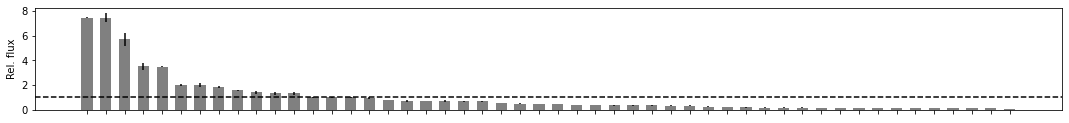

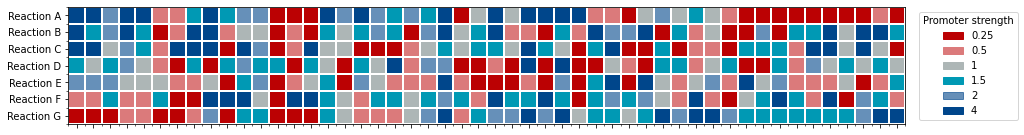

In [32]:


inds=list(train_Y.argsort()[::-1])
x=np.array(train_X)[inds]
y=np.sort(train_Y)[::-1]
fig1,fig2,axs=vis.metabolic_engineering_vis(x,y,0.1)
fig1.savefig("../../../Results/Benchmark paper/example_fluxes.svg",bbox_inches='tight')
fig2.savefig("../../../Results/Benchmark paper/example_train_space.svg",bbox_inches='tight')

In [33]:

from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from skopt import BayesSearchCV

mlr=LinearRegression(fit_intercept=True)
mlr.fit(train_X,train_Y)
pred_mlr=mlr.predict(test_X)
slope, intercept, r_value, p_value, std_err = linregress(test_Y,pred_mlr)
score_mlr=r_value**2

regr_GradBoostReg=GradientBoostingRegressor()
regr_GradBoostReg.fit(train_X,train_Y)
predict_GradBoostReg=regr_GradBoostReg.predict(test_X)
slope, intercept, r_value, p_value, std_err = linregress(test_Y,predict_GradBoostReg)
score_GradBoost=r_value**2


# log-uniform: understand as search over p = exp(x) by varying x
GBR_optimized = BayesSearchCV(
    GradientBoostingRegressor(),
    {
        "criterion":("friedman_mse","squared_error"),
        "min_samples_split":(2,3,4,5,6),
        "min_samples_leaf":(1,2,3,4,5,6,7,8),
        "max_depth":(2,3,4,5,6,7,8),
        "max_features":(1,2,3,4,5,6,7,8),
        
    },
    n_iter=25,
    cv=5)
GBR_optimized.fit(train_X, train_Y)
opt_GBR_predict=GBR_optimized.predict(test_X)
slope, intercept, r_value, p_value, std_err = linregress(test_Y,opt_GBR_predict)
score_GBR_optimized=r_value**2

KeyboardInterrupt: 

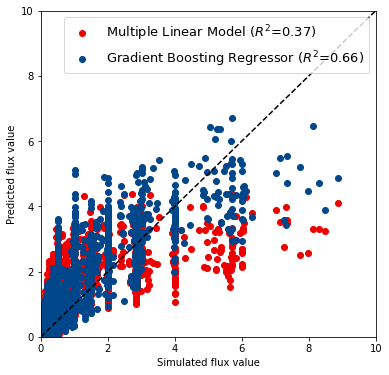

In [ ]:

fig, axs = plt.subplots(figsize=(6,6))
plt.scatter(test_Y,pred_mlr,c="#ED0000FF",label="Multiple Linear Model ($R^2$="+str(np.round(score_mlr,2))+")")
#plt.scatter(test_Y,predict_GradBoostReg,c="#00468BFF",
#            label="Gradient Boosting Tree ($R^2$="+str(np.round(score_GradBoost,2))+")")
plt.scatter(test_Y,opt_GBR_predict,c="#00468BFF",
            label="Gradient Boosting Regressor ($R^2$="+str(np.round(score_GBR_optimized,2))+")")

#plt.scatter(test_y,predicted_xgb,label="XGboost")
#plt.scatter(test_y,pred_clf,label="Neural Network")
plt.xlabel("Simulated flux value")
plt.ylabel("Predicted flux value")
plt.axline((0, 0), slope=1,color="black",linestyle="--")
plt.ylim(0,10)
plt.xlim(0,10)

plt.legend(fontsize=13)
plt.savefig("../../../Results/Benchmark paper/example_predsim.svg",bbox_inches="tight")

In [ ]:
c_test_X=comb_space[enz_names]
c_test_Y=comb_space['Enzyme_G']
opt_GBR_predict=GBR_optimized.predict(c_test_X)
slope, intercept, r_value, p_value, std_err = linregress(c_test_Y,opt_GBR_predict)
score_opt_GBR=r_value**2

mlr=LinearRegression(fit_intercept=True)
mlr.fit(train_X,train_Y)
pred_mlr=mlr.predict(c_test_X)
slope, intercept, r_value, p_value, std_err = linregress(c_test_Y,pred_mlr)
score_mlr=r_value**2

In [ ]:
#Multiple linear regression
top2000_predicted_mlr=np.argsort(pred_mlr)[::-1][0:100]
top2000_simulated_mlr=np.argsort(comb_space['Enzyme_G'])[::-1][0:100]
print(len(np.intersect1d(top2000_predicted_mlr,top2000_simulated_mlr)))

# Gradient Boosting Regressor
top2000_predicted_gbr=np.argsort(opt_GBR_predict)[::-1][0:100]
top2000_simulated_gbr=np.argsort(comb_space['Enzyme_G'])[::-1][0:100]
print(len(np.intersect1d(top2000_predicted_gbr,top2000_simulated_gbr)))

mlr_intersection=len(np.intersect1d(top2000_predicted_mlr,top2000_simulated_mlr))
gbr_intersection=len(np.intersect1d(top2000_predicted_gbr,top2000_simulated_gbr))        

0
4


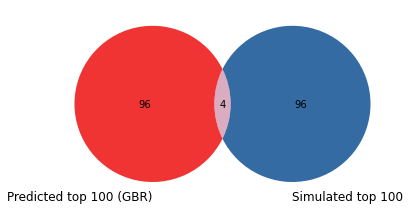

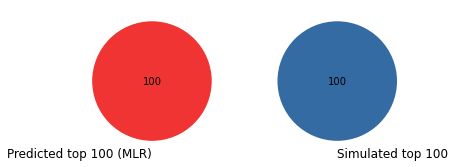

In [36]:
# library
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Use the venn2 function
v=venn2(subsets = (100-gbr_intersection, 100-gbr_intersection, gbr_intersection),
        set_labels = ('Predicted top 100 (GBR)', 'Simulated top 100'),
        set_colors=["#ED0000FF","#00468BFF"],normalize_to=1)
v.get_patch_by_id('10').set_alpha(0.8)
v.get_patch_by_id('01').set_alpha(0.8)
matplotlib.pyplot.savefig('../../../Results/Benchmark paper/venn2_NonLinear.svg',bbox_inches="tight")
plt.show()
plt.savefig("../../../Results/Benchmark paper/venn_grad.svg",bbox_inches="tight")

# Use the venn2 function
v=venn2(subsets = (100-mlr_intersection, 100-mlr_intersection, mlr_intersection), set_labels = ('Predicted top 100 (MLR)', 'Simulated top 100'),
      set_colors=["#ED0000FF","#00468BFF"],normalize_to=1)
v.get_patch_by_id('10').set_alpha(0.8)
v.get_patch_by_id('01').set_alpha(0.8)
#matplotlib.pyplot.savefig('../../../Results/Benchmark paper/venn2_LinearModel.svg',bbox_inches="tight")
plt.show()